In [37]:
# Standard python helper libraries.

import json, os, re, shutil, sys, time
import itertools, collections
from importlib import reload
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NumPy and SciPy for matrix ops
import numpy as np
import scipy.sparse
import pandas as pd
import tensorflow as tf
assert(tf.__version__.startswith("1."))
from sklearn.cross_validation import train_test_split

# NLTK for NLP utils
import nltk

# Helper libraries
from w266_common import vocabulary, tf_embed_viz, glove_helper
from w266_common import utils; reload(utils)
import rnnlm; reload(rnnlm)

<module 'rnnlm' from '/home/reachanamikasinha/project/rnnlm.py'>

In [2]:
#Using pretrained GLove embeddings
hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [3]:
hands.shape

(400003, 100)

In [4]:
#Reading back from the pickle file
start =time.time()
df_hnk = pd.read_pickle('./home_df.pkl')
stop = time.time()
print(stop-start)

25.412991046905518


In [5]:
#working_df = df_hnk
working_df = df_hnk[0:1000]

In [6]:
#Subset the data into training and test
X_train, X_test, y_train, y_test = train_test_split(working_df['reviewText'], 
                                                    #working_df['overall'],
                                                    working_df['polarity'],
                                                    test_size=.2, random_state=42)

In [6]:
print(X_train[0:5])

2369885    This unit lasted 2 summers.  At the end of the...
2371835    Nothing to write home about.  If you just want...
3781582    THIS IS MY SECOND PURCHASE OF THIS COSMETIC BA...
3422088    So I've recently purchased the 'ProPur Big' sy...
3139971    Unfortunately the dish drain is too flat, most...
Name: reviewText, dtype: object


In [7]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     /home/reachanamikasinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
#Preprocessing steps

#Changing to nltk punkt tokenizer as the periods are not getting removed
print(X_train.shape[0])

train_cnt = collections.Counter()
x_train_tokens_list = []
start = time.time()
for i in range(X_train.shape[0]):

    x_train_tokens = word_tokenize(X_train.iloc[i])
    
    

    #2. changing to lowercase and replacing numbers(are we losing any context by 
    #replacing all numbers in the review test? Are we losing any context here)
    x_tokens_canonical = utils.canonicalize_words(x_train_tokens)
    
    x_train_tokens_list.append(x_tokens_canonical)
    

    #3. Build vocabulary
    for items in x_tokens_canonical:
            train_cnt[items] += 1
            
vocab = vocabulary.Vocabulary(train_cnt, size=None)  # size=None means unlimited
total_words = sum(train_cnt.values())
print("x_train_tokens_list length", len(x_train_tokens_list))
print("Vocabulary size: {:,}".format(vocab.size))
#print("Vocabulary dict: ", vocab.word_to_id)
print("Total words ",total_words )


800
x_train_tokens_list length 800
Vocabulary size: 4,372
Total words  45945


In [9]:
#Preprocessing steps for dev set

#Changing to nltk punkt tokenizer as the periods are not getting removed
print(X_test.shape[0])

test_cnt = collections.Counter()
x_test_tokens_list = []
start = time.time()
for i in range(X_test.shape[0]):

    x_test_tokens = word_tokenize(X_test.iloc[i])
    
    

    #2. changing to lowercase and replacing numbers(are we losing any context by 
    #replacing all numbers in the review test? Are we losing any context here)
    x_tokens_canonical = utils.canonicalize_words(x_test_tokens)
    
    x_test_tokens_list.append(x_tokens_canonical)
    

    #3. Build vocabulary
    for items in x_tokens_canonical:
            test_cnt[items] += 1
            

total_words = sum(test_cnt.values())
print("x_test_tokens_list length", len(x_test_tokens_list))

print("Total words ",total_words )
print('Average number of words per review: ', total_words/X_test.shape[0])
#Average number of words per review helps us figure out the sequence length

200
x_test_tokens_list length 200
Total words  12199
Average number of words per review:  60.995


In [51]:
print(x_train_tokens_list[0])

['saw', 'this', 'book', 'in', 'my', 'local', 'library', '.', 'borrowed', 'it', 'and', 'simply', 'loved', 'it', '.', 'could', "n't", 'wait', 'to', 'get', 'my', 'own', 'copy', '.', 'just', 'love', 'all', 'the', 'beautiful', 'pictures', 'in', 'here', '.', 'finally', 'got', 'it', 'from', 'amazon', 'and', 'it', "'s", 'mine', '!', '!', 'no', 'need', 'to', 'borrow', 'from', 'the', 'library', 'anymore', '.']


In [10]:
#Converting all reviews to ids 
train_id_list = []
for item in x_train_tokens_list:
    train_id_list.append(vocab.words_to_ids(item))
    
test_id_list = []
for item in x_test_tokens_list:
    test_id_list.append(vocab.words_to_ids(item))    

In [47]:
print((x_train_tokens_list[0]))

['saw', 'this', 'book', 'in', 'my', 'local', 'library', '.', 'borrowed', 'it', 'and', 'simply', 'loved', 'it', '.', 'could', "n't", 'wait', 'to', 'get', 'my', 'own', 'copy', '.', 'just', 'love', 'all', 'the', 'beautiful', 'pictures', 'in', 'here', '.', 'finally', 'got', 'it', 'from', 'amazon', 'and', 'it', "'s", 'mine', '!', '!', 'no', 'need', 'to', 'borrow', 'from', 'the', 'library', 'anymore', '.']


In [53]:
print((train_id_list[0]))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 12, 10, 16, 17, 18, 19, 20, 7, 21, 22, 10, 23, 24, 25, 26, 27, 28, 6, 29, 10, 30, 31, 12, 32, 33, 13, 12, 34, 35, 36, 36, 37, 38, 19, 39, 32, 26, 9, 40, 10]


In [54]:
print((x_test_tokens_list[0]))

['i', 'bought', 'this', 'because', 'i', 'have', "n't", 'found', 'time', 'to', 'take', 'the', 'class', 'and', 'found', 'it', "'s", 'pretty', 'easy', 'to', 'follow', 'along', 'and', 'teach', 'yourself', 'everything', 'in', 'the', 'book', '.', 'there', 'is', 'step', 'by', 'step', 'instructions', 'for', 'different', 'designs', 'and', 'ideas', 'and', 'lots', 'of', 'hints', 'and', 'tricks', 'for', 'working', 'with', 'fondant', 'and', 'gumpaste', '.']


In [55]:
print((test_id_list[0]))

[41, 195, 4, 197, 41, 83, 17, 247, 243, 19, 257, 26, 424, 13, 247, 12, 34, 326, 234, 19, 608, 1163, 13, 1282, 1192, 344, 6, 26, 5, 10, 380, 79, 623, 426, 623, 179, 43, 659, 399, 13, 415, 13, 260, 74, 3015, 13, 637, 43, 806, 70, 371, 13, 996, 10]


In [58]:
print(max((train_id_list)))

[4301, 76, 4302, 305, 4149, 570, 166, 76, 54, 41, 138, 4, 145, 223, 80, 19, 235, 95, 44, 704, 168, 76, 41, 4303, 26, 147, 6, 12, 4304, 3428, 970, 10, 915, 706, 1326, 706, 50, 17, 412, 706, 983, 343, 19, 235, 12, 43, 1457, 76, 12, 34, 23, 489, 2088, 43, 245, 36, 979, 13, 1612, 2496, 498, 289, 12, 232, 87, 2659, 10]


In [59]:
review_lengths = [len(review) for review in train_id_list]
print("Shortest review:", min(review_lengths))
print("Longest review:",max(review_lengths))


Shortest review: 2
Longest revies: 574


[]

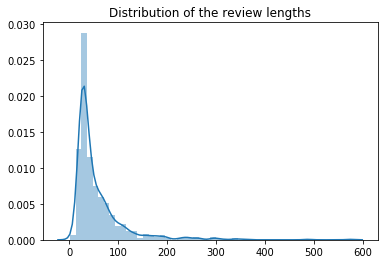

In [62]:
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

In [63]:
pd.DataFrame(review_lengths).describe()

,0
count,800.000000
mean,57.431250
std,55.240267
min,2.000000
25%,27.000000
50%,37.000000
75%,68.000000
max,574.000000


In [17]:
#Adding padding to each review less than max_length and cutting off reviews greater than max length
max_length = 200

train_ids, z = utils.pad_np_array(train_id_list, max_len=200) 
test_ids, z = utils.pad_np_array(train_id_list, max_len=200) 

In [97]:
print(train_ids.shape)

(800, 200)


In [14]:
print(train_ids[0])

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 12 10 16 17 18 19 20  7 21 22 10 23
 24 25 26 27 28  6 29 10 30 31 12 32 33 13 12 34 35 36 36 37 38 19 39 32 26
  9 40 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [26]:

print(len(train_ids))
print(len(X_train))
print(train_ids[0:100])
print(X_train[0:2])

219753
800
[   0  776   44 1112    2 1250  777   41  776    2 3275 2181 2181    2
    2   41 2498    2    2    2    2    2 2181 3776   44    2    2    2
   41 3275    2   44    2    2   10    2    2 3275 2181    2    2 2181
 1112    2 3873    2   41 1250    2   44 2498 3873    2  776   41    2
    2    2    2    2    2 2181    2    2 3873    2   41 1250   10    2
    2 3776 2181 2935    2 3873 2498 2028 1250    2 1112   44   41 1250
    2 1250 2181    2    2    2 1250    2    2    2    2 2181 1112 2498
    2 3776]
29     Saw this book in my local library.  Borrowed i...
535    i purchased this for a friend who enjoys cake ...
Name: reviewText, dtype: object


In [13]:
print(y_train.shape)

(800,)


In [12]:
reload(rnnlm)

TF_GRAPHDIR = "/tmp/w266/a4_graph"

# Clear old log directory.
shutil.rmtree(TF_GRAPHDIR, ignore_errors=True)

lm = rnnlm.RNNLM(V=vocab.size, H=200, num_layers=2, gl_embed=hands.W)
lm.BuildCoreGraph()
lm.BuildTrainGraph()
#lm.BuildSamplerGraph()

summary_writer = tf.summary.FileWriter(TF_GRAPHDIR, lm.graph)

self.output_ (?, ?, 200)
self.output_[:, -1] (?, 200)
self.predictions (?, 1)
self.target (?, ?)


In [46]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=0.1):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0
    loss = lm.loss_
    if train:
        #train_op = lm.train_step_
        use_dropout = True
        
    else:
        #train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        

    for i, (w, y) in enumerate(batch_iterator, 0):
        #print('w shape', w.shape)
        #print('y shape', y.shape)
        cost = 0.0
        # At first batch in epoch, get a clean intitial state.
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})
        
        
        #### YOUR CODE HERE ####
        
       
        feed_dict = {lm.input_w_: w, lm.initial_h_: h, lm.target_y_: y,  lm.learning_rate_: learning_rate, lm.use_dropout_ : use_dropout}

        cost,h, _ = session.run([loss, lm.final_h_,lm.optimizer], feed_dict=feed_dict)   
         
        #### END(YOUR CODE) ####
        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time

        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print("[batch {:d}]: seen {:d} words at {:.1f} wps, loss = {:.3f}".format(
                i, total_words, avg_wps, avg_cost))
            tick_time = time.time()  # reset time ticker

    return total_cost / total_batches

In [103]:
def score_dataset(lm, session, ids, name="Data"):
    # For scoring, we can use larger batches to speed things up.
    bi = utils.rnnlm_batch_generator(ids, batch_size=100, max_time=200)
    cost = run_epoch(lm, session, batch_iterator=bi, 
                     learning_rate=1.0, train=False, 
                     verbose=False, tick_s=3600)
    print("{:s}: avg. loss: {:.03f}  (perplexity: {:.02f})".format(name, cost, np.exp(cost)))
    
    return cost

In [44]:
def batch_generator(ids, labels, batch_size=100):
    
    n_batches = len(ids)//batch_size
    ids, labels = ids[:n_batches*batch_size], labels[:n_batches*batch_size]
    
    for ii in range(0, len(ids), batch_size):
        yield ids[ii:ii+batch_size], labels[ii:ii+batch_size]
        

In [20]:
# Training parameters
V= vocab.size
max_time = 200 #max_sequence_length
batch_size = 50
learning_rate = 0.01
num_epochs = 2
#num_epochs = 5
# Model parameters
model_params = dict(V=vocab.size, 
                    H=100, 
                    softmax_ns=200,
                    num_layers=1,
                   gl_embed=hands.W)

TF_SAVEDIR = "/tmp/w266/a4_model"
checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [47]:
# Will print status every this many seconds
print_interval = 5

lm = rnnlm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
if not os.path.isdir(TF_SAVEDIR):
    os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)

    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()
        #bi = utils.rnnlm_batch_generator(train_ids, y_train, batch_size, max_time)
        bi = batch_generator(train_ids, y_train, batch_size)
        print("[epoch {:d}] Starting epoch {:d}".format(epoch, epoch))
        #### YOUR CODE HERE ####
        # Run a training epoch.
        
        avg_cost = run_epoch(lm, session, bi,
              train=True, verbose=False,
              tick_s=10, learning_rate=0.01)
    
        
        
        #### END(YOUR CODE) ####
        
        if (i % print_interval == 0):
            print("[epoch %d] seen %d minibatches" % (epoch, i))
        
        print("[epoch {:d}] Completed in {:s}".format(epoch, utils.pretty_timedelta(since=t0_epoch)))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
    
        
        
        
        print("[epoch {:d}]".format(epoch), end=" ")
#       score_dataset(lm, session, train_ids, name="Train set")
#         print("[epoch {:d}]".format(epoch), end=" ")
#         score_dataset(lm, session, test_ids, name="Test set")
        print("")
    
    # Save final model
    saver.save(session, trained_filename)

self.output_ (?, ?, 100)
self.output_[:, -1] (?, 100)
self.predictions (?, 1)
self.target (?,)
[epoch 1] Starting epoch 1
[epoch 1] Completed in 0:00:06
[epoch 1] 
[epoch 2] Starting epoch 2
[epoch 2] Completed in 0:00:06
[epoch 2] 
